# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score !

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [263]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns

pio.renderers.default = 'png'
from IPython.display import display

# Read file with labels

In [148]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [149]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [150]:
data.describe()

,age,new_user,total_pages_visited,converted
count,284580.000000,284580.000000,284580.000000,284580.000000
mean,30.564203,0.685452,4.873252,0.032258
std,8.266789,0.464336,3.341995,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [151]:
data = data[data.age<60]

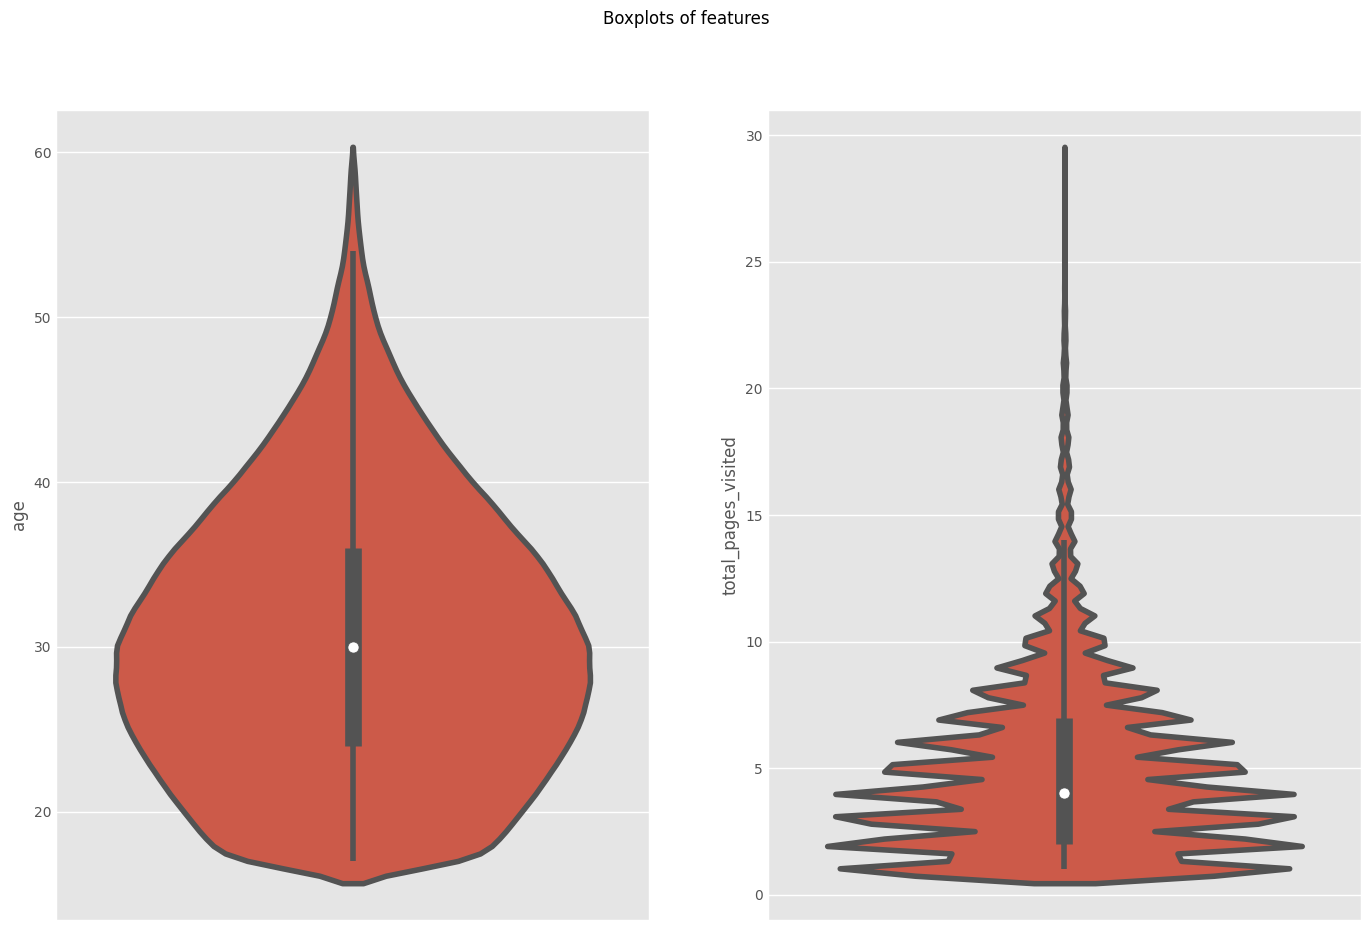

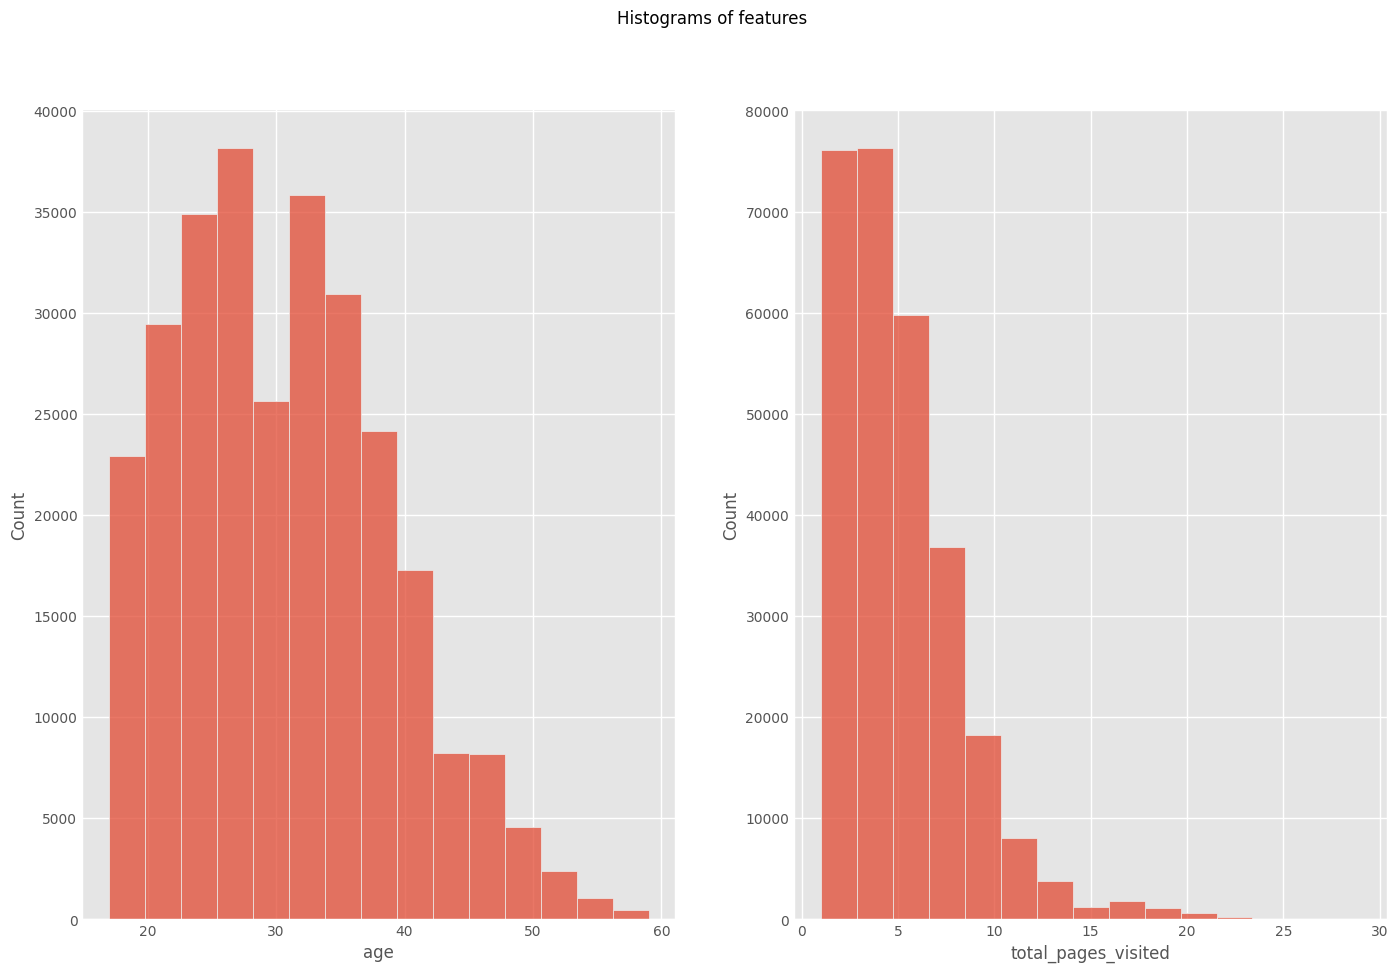

In [152]:
plt.style.use('ggplot')
#make subplots of boxplots for each feature to show outliers
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
#show y axis
fig.suptitle('Boxplots of features')
sns.violinplot(ax=axes[0], data=data, y='age')
sns.violinplot(ax=axes[1], data=data, y='total_pages_visited')
plt.show()

#make subplots of histograms for each feature
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.suptitle('Histograms of features')
sns.histplot(ax=axes[0], data=data, x='age', bins=15)
sns.histplot(ax=axes[1], data=data, x='total_pages_visited', bins=15)
plt.show()



# Explore dataset

In [153]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)

# EDA 

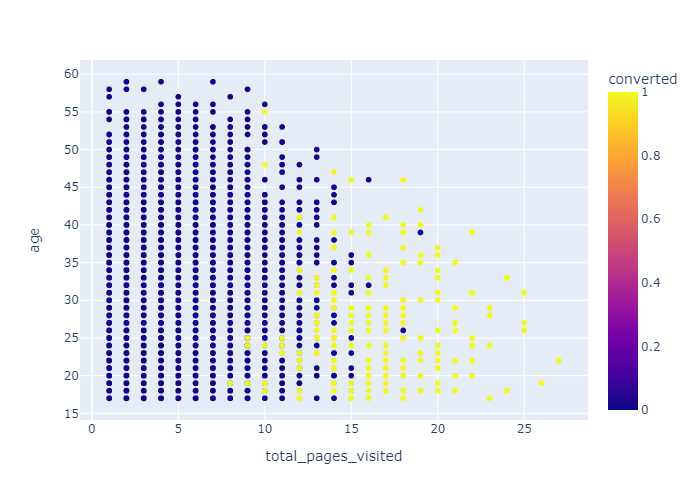

In [154]:
fig = px.scatter(data_sample, x='total_pages_visited', y='age',color='converted')
fig.show()

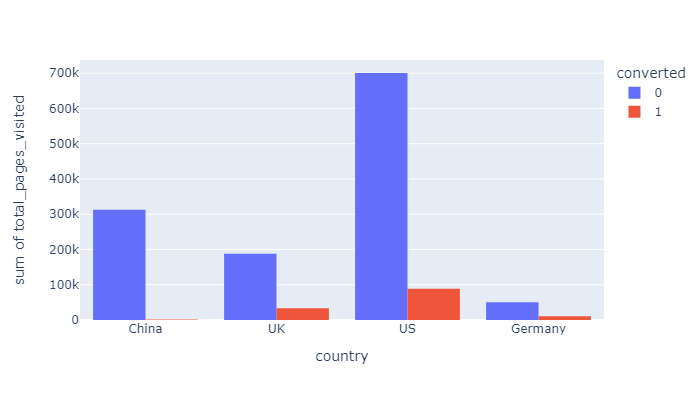

In [155]:
fig = px.histogram(data, x="country", y="total_pages_visited",
             color='converted', barmode='group',
             height=400)
fig.show()

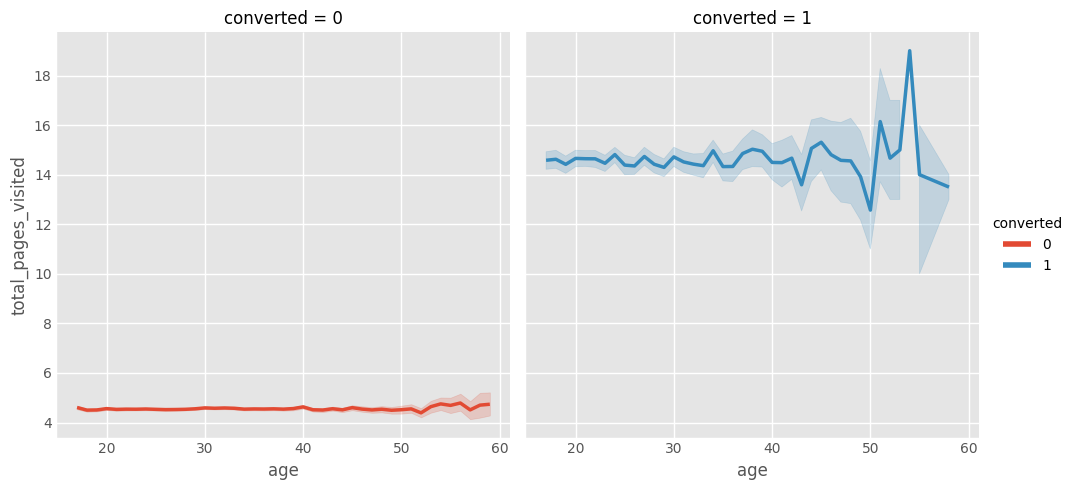

In [158]:
sns.relplot(
    data=data, kind="line",
    x="age", y="total_pages_visited", col="converted",
    hue="converted", linewidth=2.5
)

C:\Users\swell\AppData\Local\Temp\ipykernel_20016\1990399123.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



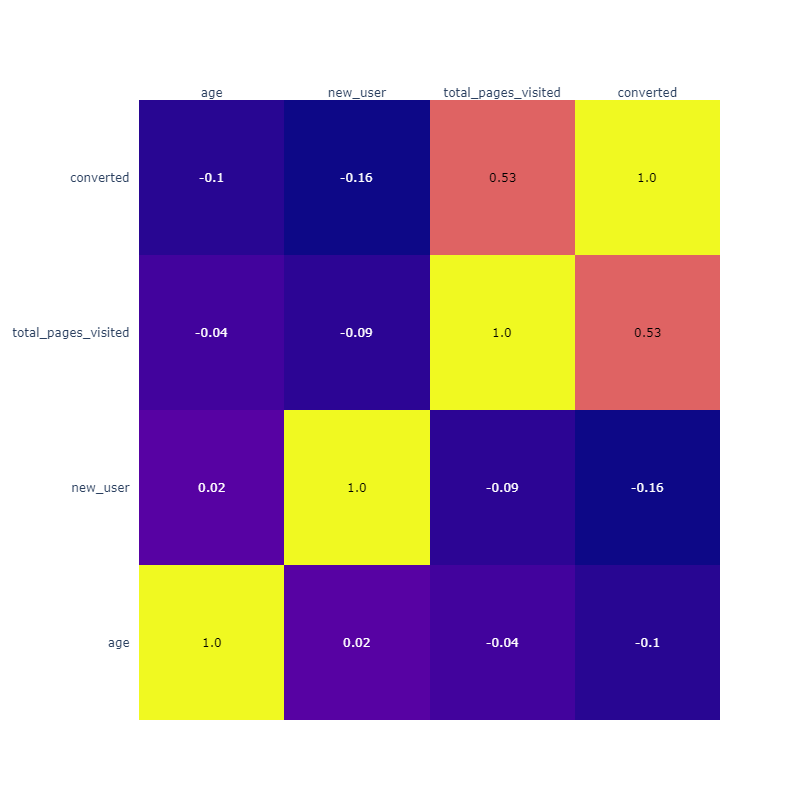

In [125]:
# Correlation matrix
corr_matrix = pd.DataFrame(data_sample).corr().round(2)
import plotly.figure_factory as ff

fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.tolist(),
                                  y = corr_matrix.index.tolist())
#set the size of the figure
fig.update_layout( width=800, height=800)

fig.show()

In [126]:
def Count_plot(feature):
    pal = ['#a986c0',"#9fba81"]
    fig, ax = plt.subplots(figsize=(8,6))
    sns.countplot(x=feature, hue='converted',data=data, ax=ax, palette = pal)
    ax.set_title('User '+feature.capitalize()+' Distribution', fontsize=20)
    ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.legend(labels=['Not Converted','Converted'],fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    plt.show()

In [127]:
def Mean_rate(feature):
    pal = ['#D1667C',"#B9C0C9","#F3AB60","#689FB0"]
    fig, ax = plt.subplots(figsize=(8,6))
    sns.barplot(x=feature, y = 'converted', data=data, errorbar=('ci', 0), ax=ax,palette = pal)
    ax.set_title('Mean Conversion Rate by '+feature.capitalize(), fontsize=20)
    def to_percent(temp, position):
            return '%1.0f'%(100*temp) + '%'
    plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    plt.show()

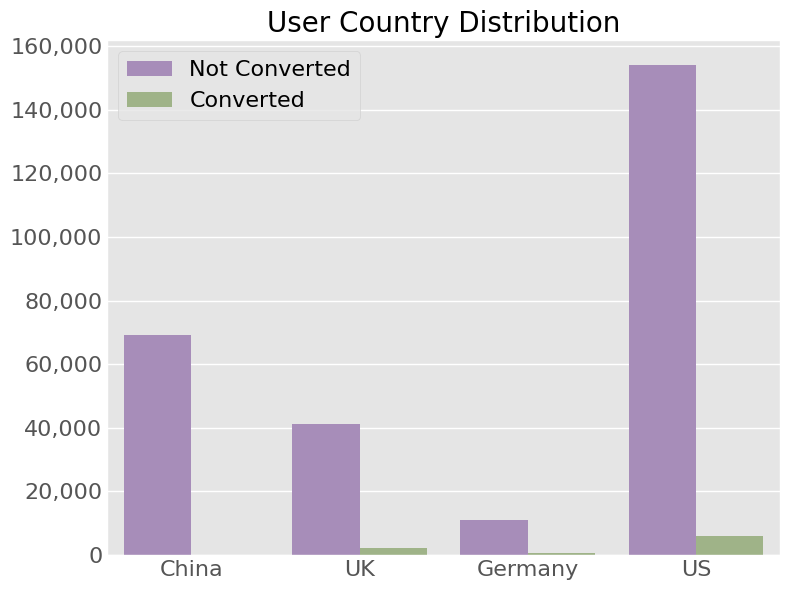

In [128]:
Count_plot('country')

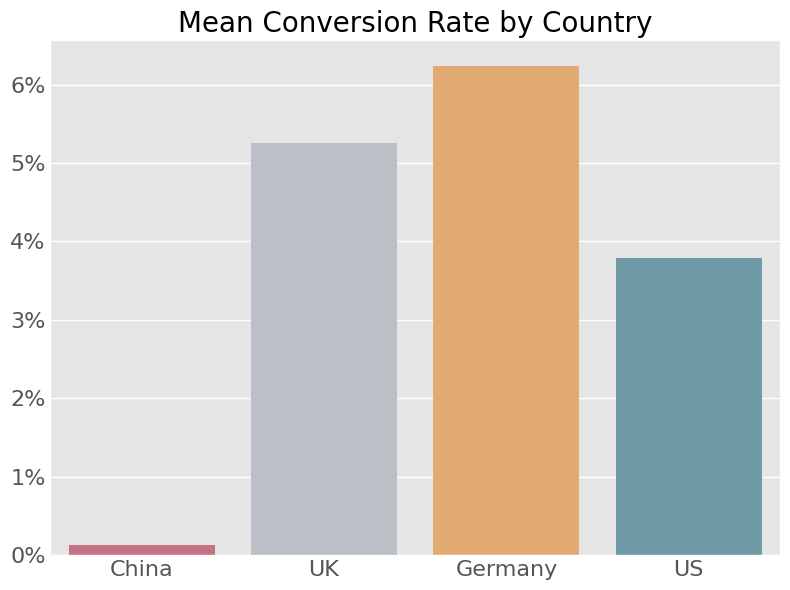

In [129]:
Mean_rate('country')

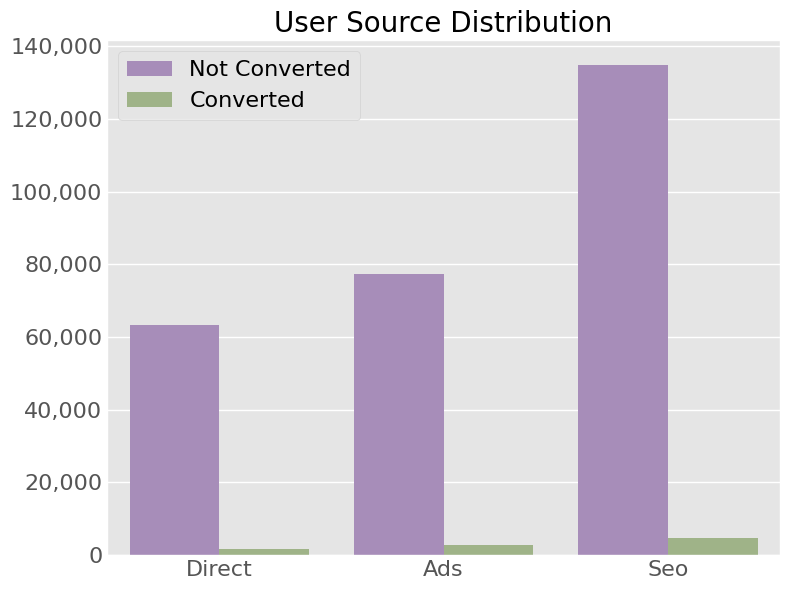

In [130]:
Count_plot('source')

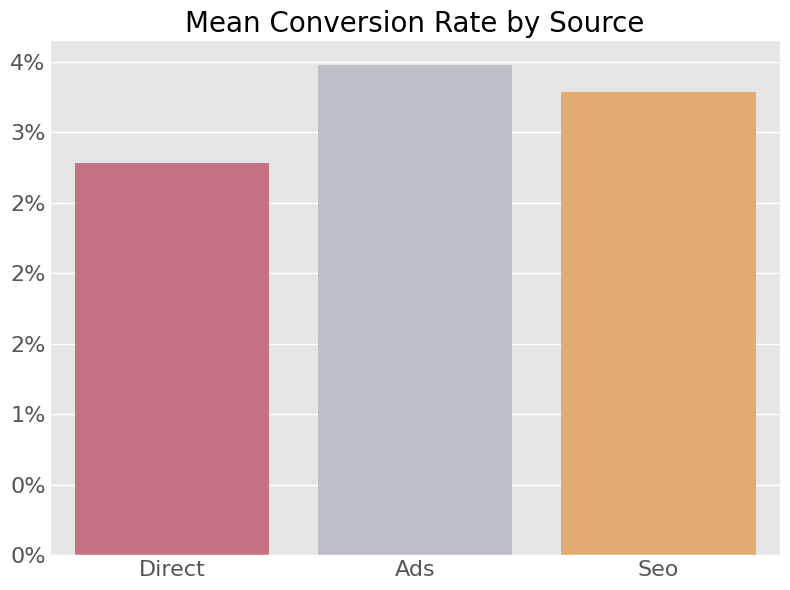

In [131]:
Mean_rate('source')

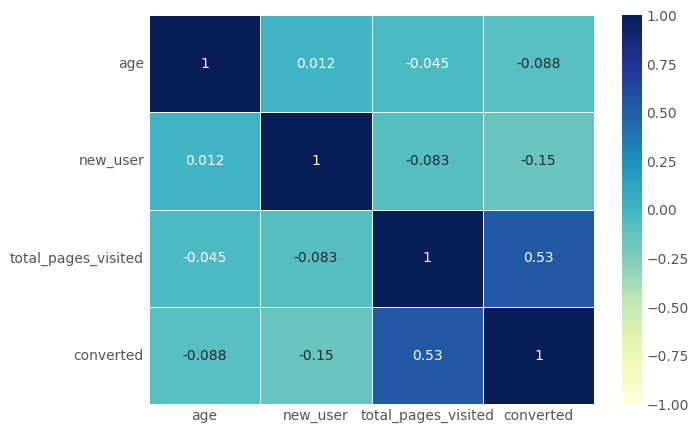

In [136]:
sns.heatmap(data[['age','new_user','total_pages_visited', 'converted']].corr(), annot=True, cmap='YlGnBu', vmin=-1, vmax=1,cbar=True, linewidths=0.5)
plt.show()

In [139]:
def plot_numeric_dist_age(feature):
    pal = ['#a986c0',"#9fba81"]
    fig, ax = plt.subplots(figsize=(8,6)) 
    sns.kdeplot(data=data, x=feature, hue='converted', palette=pal,ax=ax,linewidth=2)   
    ax.set_xlabel('Age')
    ax.set_title('User Age Distribution', fontsize=20)
    plt.legend(labels=['Converted','Not Converted'],fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

In [140]:
def plot_numeric_dist_visit(feature):
    pal = ['#a986c0',"#9fba81"]
    fig, ax = plt.subplots(figsize=(8,6)) 
    sns.kdeplot(data=data, x=feature, hue='converted', palette=pal,ax=ax,linewidth=2)   
    ax.set_xlabel('Total Pages Visited')
    ax.set_title('Total Page Visit Distribution', fontsize=20)
    plt.legend(labels=['Converted','Not Converted'],fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

In [141]:
def plot_numeric_mean_age(feature):    
    fig, ax = plt.subplots(figsize=(8,6)) 
    grouped = data.groupby(feature)['converted'].mean().reset_index()
    ax.plot(grouped[feature], grouped['converted'],'.-',color="#689FB0",linewidth=2)
    def to_percent(temp, position):
        return '%1.0f'%(100*temp) + '%'
    plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))
    ax.set_title('Mean Conversion Rate by Age', fontsize=20)
    ax.set_xlabel('Age')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    plt.show()

In [142]:
def plot_numeric_mean_visit(feature):    
    fig, ax = plt.subplots(figsize=(8,6)) 
    grouped = data.groupby(feature)['converted'].mean().reset_index()
    ax.plot(grouped[feature], grouped['converted'],'.-',color="#689FB0",linewidth=2)
    def to_percent(temp, position):
        return '%1.0f'%(100*temp) + '%'
    plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))
    ax.set_title('Mean Conversion Rate by Page Visit', fontsize=20)
    ax.set_xlabel('Total Pages Visited')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    plt.show()

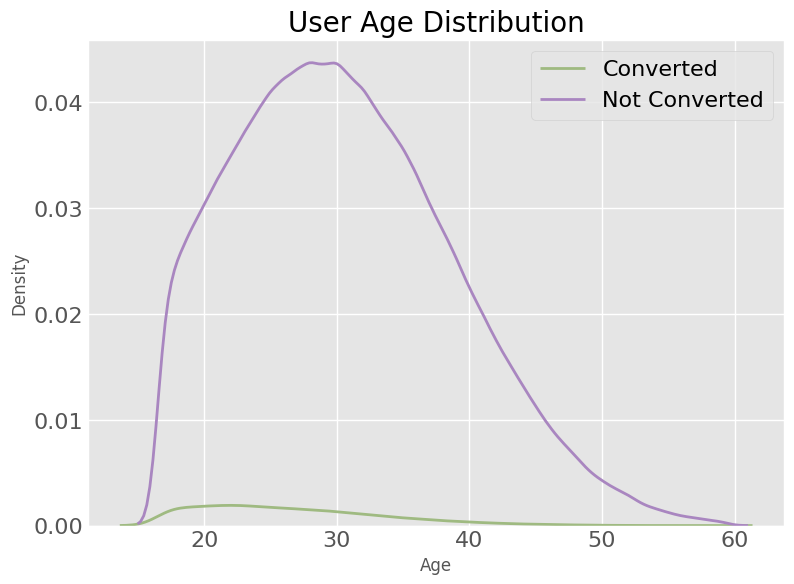

In [159]:
plot_numeric_dist_age('age')

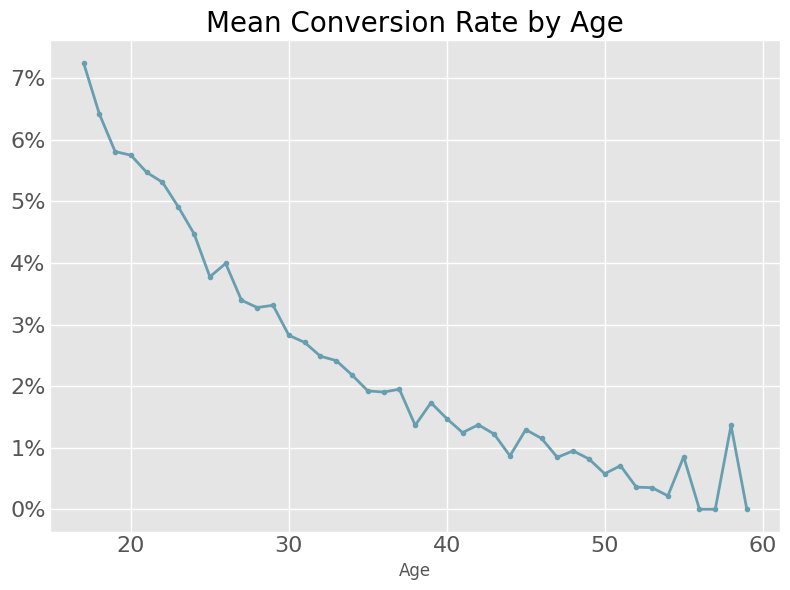

In [160]:
plot_numeric_mean_age('age')

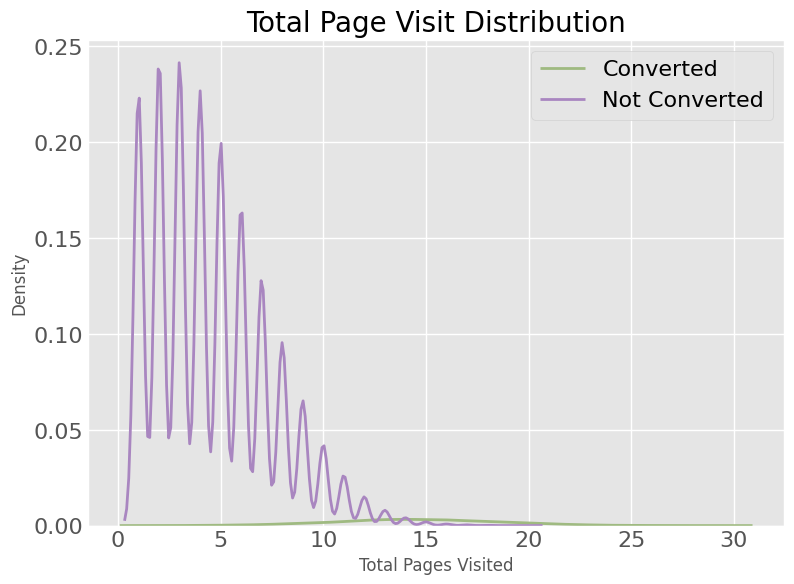

In [161]:
plot_numeric_dist_visit('total_pages_visited')

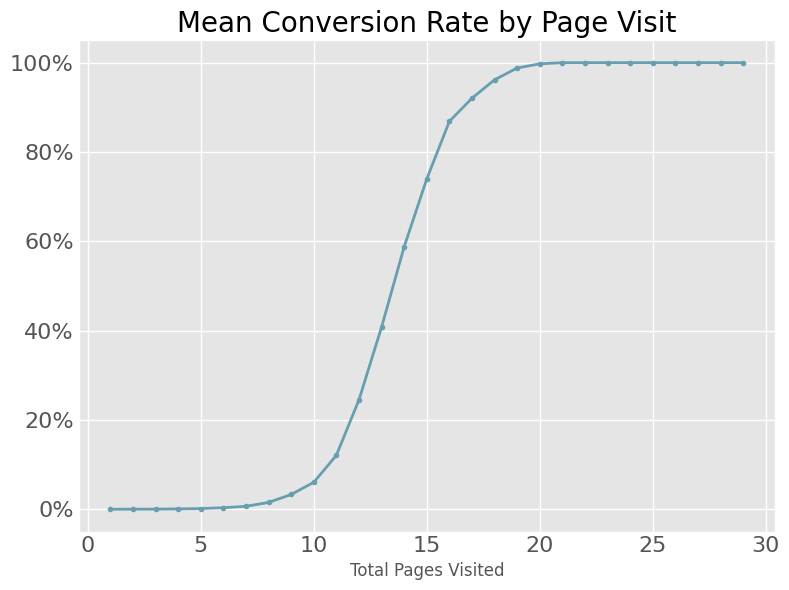

In [162]:
plot_numeric_mean_visit('total_pages_visited')

# Make your model

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [98]:
data.dropna(inplace=True)

In [200]:
features_list = ['total_pages_visited']
numeric_indices = [0]
categorical_indices = []
target_variable = 'converted'

In [186]:
features_list = ['age', 'new_user', 'total_pages_visited']
numeric_indices = [0]
categorical_indices = []
target_variable = 'converted'

In [227]:
features_list = ['age', 'new_user', 'total_pages_visited','country', 'source']
target_variable = 'converted'

In [228]:
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['age', 'new_user', 'total_pages_visited', 'country', 'source'], dtype='object')



In [229]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0,stratify=Y)

Y_train.mean(), Y_test.mean() 

(0.032273808529255286, 0.032273382813324425)

In [230]:
numeric_features = []
categorical_features = []
for i,t in X.dtypes.items():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Numeric features ', numeric_features)
print('Categorical features ', categorical_features)

Numeric features  ['age', 'new_user', 'total_pages_visited']
Categorical features  ['country', 'source']


In [231]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)
                ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [202]:
# # Divide dataset Train set & Test set 
# print("Dividing into train and test sets...")
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
# print("...Done.")
# print()

Dividing into train and test sets...
...Done.



# Part 2 : Model training

In [232]:
DC = DummyClassifier(strategy='most_frequent')
DC.fit(X_train, Y_train)
Y_pred = DC.predict(X_train)
print("accuracy score of the dummy model: ", accuracy_score(Y_train, Y_pred))
print("f1-score of the dummy model: ", f1_score(Y_train, Y_pred))

accuracy score of the dummy model:  0.9677261914707447
f1-score of the dummy model:  0.0


In [233]:
model = LogisticRegression()
params = {
        'solver': ['saga', 'lbfgs'],
        'penalty': ['l2'],
        'C' : [1000, 100, 10, 1, 0.1]
        }

In [237]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
gridsearch = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, cv=cv, scoring='f1')
gridsearch.fit(X_train, Y_train)

print('-'*50)
print("Best: %f using %s" % (gridsearch.best_score_, gridsearch.best_params_))

--------------------------------------------------
Best: 0.762564 using {'C': 1000, 'penalty': 'l2', 'solver': 'saga'}


In [239]:
logreg_class = LogisticRegression(C= 1000, penalty='l2',solver='saga')
logreg_class.fit(X_train, Y_train)

train_pred = logreg_class.predict(X_train)
test_pred = logreg_class.predict(X_test)

print("f1-score on train set : ", f1_score(Y_train, train_pred))
print("f1-score on test set : ", f1_score(Y_test, test_pred))

f1-score on train set :  0.7631182147165259
f1-score on test set :  0.7648125755743652


In [240]:
col_names = list(preprocessor.transformers_[0][1].get_feature_names_out()) + list(preprocessor.transformers_[1][1].get_feature_names_out())
coef = logreg_class.coef_

feature_imp = pd.DataFrame(columns=col_names, data=coef)
display(feature_imp)

,age,new_user,total_pages_visited,country_Germany,country_UK,country_US,source_Direct,source_Seo
0,-0.623413,-0.802214,2.534232,3.871524,3.720113,3.371191,-0.218914,-0.063022


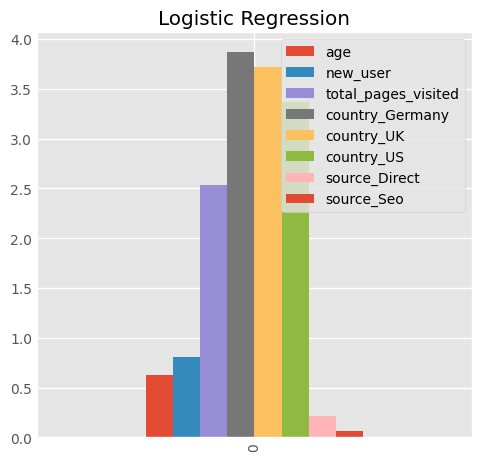

In [242]:
feature_imp.abs().plot(kind='bar', figsize=(5, 5))
plt.title('Logistic Regression')
plt.show()

In [243]:
DT_class = DecisionTreeClassifier()
params = {
        'max_depth': [4,8,12,16],
        'min_samples_split': [2,4,8,12,16],
        'min_samples_leaf' : [1,4,6,8,10]
        }

gridsearch = GridSearchCV(DT_class, param_grid = params, n_jobs=-1, cv = 5,scoring='f1') 
gridsearch.fit(X_train, Y_train)
print("Best: %f using %s" % (gridsearch.best_score_, gridsearch.best_params_))

Best: 0.745221 using {'max_depth': 8, 'min_samples_leaf': 6, 'min_samples_split': 16}


In [244]:
DT_class = DecisionTreeClassifier(max_depth= 8,min_samples_leaf= 6, min_samples_split= 16)
DT_class.fit(X_train,Y_train)

train_pred = DT_class.predict(X_train)
test_pred = DT_class.predict(X_test)

print("f1-score on train set : ", f1_score(Y_train, train_pred))
print("f1-score on test set : ", f1_score(Y_test, test_pred))

f1-score on train set :  0.7577327441718725
f1-score on test set :  0.751219512195122


In [246]:
model = RandomForestClassifier()
params = {
        'max_depth': [6,8,10,12],
        'min_samples_split': [12,16,20,24],
        'n_estimators': [80,100,120,140]
        }

gridsearch = GridSearchCV(model, param_grid = params, n_jobs=-1, cv = 5,scoring='f1') 
gridsearch.fit(X_train, Y_train)
print("Best: %f using %s" % (gridsearch.best_score_, gridsearch.best_params_))

Best: 0.758671 using {'max_depth': 10, 'min_samples_split': 24, 'n_estimators': 120}


In [247]:
randomforest_class = RandomForestClassifier(random_state=42,max_depth= 10, min_samples_split= 24, n_estimators= 120)
randomforest_class.fit(X_train, Y_train)

train_pred = randomforest_class.predict(X_train)
test_pred = randomforest_class.predict(X_test)

print("f1-score on train set : ", f1_score(Y_train, train_pred))
print("f1-score on test set : ", f1_score(Y_test, test_pred))

f1-score on train set :  0.7715782281940332
f1-score on test set :  0.7608629595867518


In [250]:
col_names = list(preprocessor.transformers_[0][1].get_feature_names_out()) + list(preprocessor.transformers_[1][1].get_feature_names_out())
coef = randomforest_class.feature_importances_

feature_imp = pd.DataFrame(index = col_names, data=coef)
display(feature_imp)

,0
age,0.039967
new_user,0.041602
total_pages_visited,0.884880
country_Germany,0.007420
country_UK,0.011277
country_US,0.011666
source_Direct,0.001614
source_Seo,0.001575


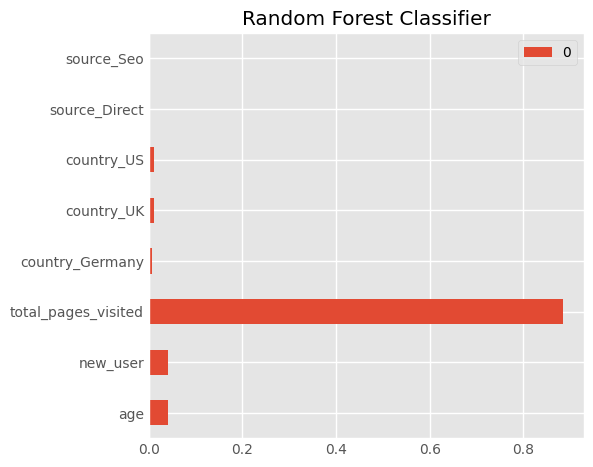

In [252]:
feature_imp.abs().plot(kind='barh', figsize=(5, 5))
plt.title('Random Forest Classifier')
plt.show()

looking at the chart of feature importance we can see that the most important feature is total_pages_visited for the model to predict the conversion rate. So we will use this feature to train our random forest model.

Let's now look at the performance of an ada boost model. ADA Boost is a boosting algorithm that uses decision trees as base learners. It is a sequential algorithm that works by fitting a sequence of weak learners on repeatedly modified versions of the data. It improves weak learners by paying more attention to cases where the predecessor underperformed. Weak learners are typically decision trees with a single split. AdaBoost is sensitive to noisy data and outliers.

to find the best parameters for our model we will use grid search. Grid search is an approach to parameter tuning that will methodically build and evaluate a model for each combination of algorithm parameters specified in a grid.

In [253]:
#ada boost model
ada_class = AdaBoostClassifier()
params = {
        'n_estimators': [50,100,150,200],
        'learning_rate': [0.1,0.5,1,1.5]
        }

gridsearch = GridSearchCV(ada_class, param_grid = params, n_jobs=-1, cv = 5,scoring='f1')
gridsearch.fit(X_train, Y_train)
print("Best: %f using %s" % (gridsearch.best_score_, gridsearch.best_params_))

Best: 0.761002 using {'learning_rate': 1.5, 'n_estimators': 200}


In [254]:
ada_class = AdaBoostClassifier(learning_rate=1.5, n_estimators=200)
ada_class.fit(X_train,Y_train)
train_pred = ada_class.predict(X_train)
test_pred = ada_class.predict(X_test)
print("f1-score on train set : ", f1_score(Y_train, train_pred))
print("f1-score on test set : ", f1_score(Y_test, test_pred))

f1-score on train set :  0.7610699712860813
f1-score on test set :  0.7653648198607327


XG Boost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. Decision trees are simply put, a flowchart-like structure in which each internal node represents a test on an attribute, each branch represents an outcome of the test, and each leaf node represents a class label. In prediction problems involving unstructured data (images, text, etc.) artificial neural networks tend to outperform all other algorithms or frameworks. XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.

XG Boost demarkates itself from other gradient boosting algorithms by using a more regularized model formalization to control over-fitting, which gives it better performance. It also has an in-built mechanism to handle missing values, which is a common occurrence in data sets in the real world. XGBoost is also parallelized and is capable of running on a large number of cores, which gives it an edge over other algorithms when it comes to execution speed.

In [256]:
#xgboost model
xgb_class = XGBClassifier()
params = {
        'min_child_weight': [4,8,12],
        'n_estimators': [20, 30, 40],
        'gamma': [0.5, 1, 1.5],
        'max_depth': [4,8,12],
        'subsample': [0.6,0.8,1.0],
        'colsample_bytree': [0.6,0.8,1.0]
        }

gridsearch = GridSearchCV(xgb_class, param_grid = params, n_jobs=-1, cv = 5,scoring='f1')
gridsearch.fit(X_train, Y_train)
print("Best: %f using %s" % (gridsearch.best_score_, gridsearch.best_params_))

Best: 0.762764 using {'colsample_bytree': 1.0, 'gamma': 1, 'max_depth': 4, 'min_child_weight': 12, 'n_estimators': 40, 'subsample': 0.6}


In [257]:
xgb_class = XGBClassifier(max_depth= 4, n_estimators = 40, min_child_weight= 12,colsample_bytree=1.0,gamma=1,subsample=0.6)
xgb_class.fit(X_train,Y_train)
train_pred = xgb_class.predict(X_train)
test_pred = xgb_class.predict(X_test)
print("f1-score on train set : ", f1_score(Y_train, train_pred))
print("f1-score on test set : ", f1_score(Y_test, test_pred))

f1-score on train set :  0.7662542182227222
f1-score on test set :  0.76765855124737


In [258]:
v_clf = VotingClassifier(estimators=[
         ('logreg', logreg_class), ('xgb', xgb_class), ('forest',randomforest_class)],voting='soft',weights=[2,3,1])
v_clf = v_clf.fit(X_train, Y_train)
train_pred = v_clf.predict(X_train)
test_pred = v_clf.predict(X_test)
print("f1-score on train set : ", f1_score(Y_train, train_pred))
print("f1-score on test set : ", f1_score(Y_test, test_pred))

f1-score on train set :  0.7668471720818291
f1-score on test set :  0.7677496991576415


Confusion matrix on train set : 


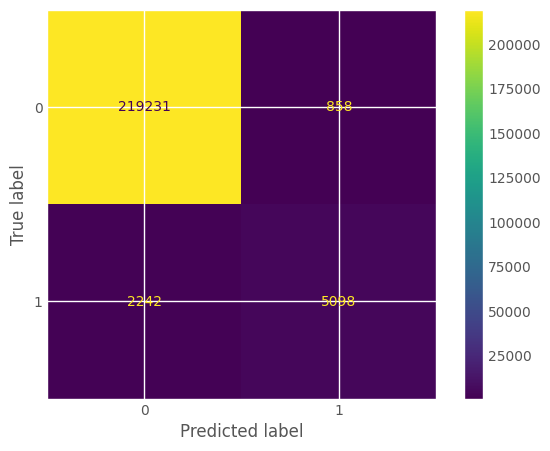

Confusion matrix on test set : 


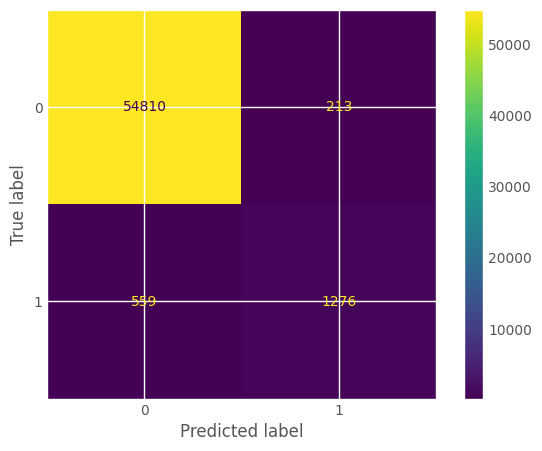

In [259]:
print("Confusion matrix on train set : ")
cm_train = confusion_matrix(Y_train, train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=v_clf.classes_)
disp_train.plot()
plt.show()
print("Confusion matrix on test set : ")
cm_test = confusion_matrix(Y_test, test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=v_clf.classes_)
disp_test.plot()
plt.show()

In [260]:
fpr, tpr, _ = roc_curve(Y_test, test_pred)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
prec, recall, _ = precision_recall_curve(Y_test, test_pred, pos_label=v_clf.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()

NameError: name 'RocCurveDisplay' is not defined

In [270]:
models = [logreg_class, randomforest_class, ada_class, xgb_class, v_clf]
model_names = ['Logistic Regression', 'Random Forest', 'Ada Boost', 'XGBoost', 'Voting Classifier']
for model, name in zip(models, model_names):
    print(name)
    scores = cross_val_score(model, X_test, Y_test, cv=5, scoring='f1')
    print(f"{name} has a f1-score of {round(scores.mean(),4)} with standard deviation of {round(scores.std(),4)}")



Logistic Regression
Logistic Regression has a f1-score of 0.7667 with standard deviation of 0.0166
Random Forest
Random Forest has a f1-score of 0.756 with standard deviation of 0.0192
Ada Boost
Ada Boost has a f1-score of 0.7617 with standard deviation of 0.0188
XGBoost
XGBoost has a f1-score of 0.7634 with standard deviation of 0.0223
Voting Classifier
Voting Classifier has a f1-score of 0.7658 with standard deviation of 0.0221


# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [272]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

v_clf.fit(X,Y)

# Predictions on full dataset
pred = v_clf.predict(X)
print("f1-score on full dataset : ", f1_score(Y, pred))

f1-score on full set :  0.7668088685934027


In [273]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

X_without_labels = data_without_labels.loc[:, features_list]
print(data_without_labels.head())

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Preprocessing data...")
X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")

print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 5)
  country  age  new_user  source  total_pages_visited
0      UK   28         0     Seo                   16
1      UK   22         1  Direct                    5
2   China   32         1     Seo                    1
3      US   32         1     Ads                    6
4   China   25         0     Seo                    3
Preprocessing data...
...Done
[[-0.30785036 -1.47500125  3.32618654  0.          1.          0.
   0.          1.        ]
 [-1.03883145  0.67796553  0.0376866   0.          1.          0.
   1.          0.        ]
 [ 0.17947036  0.67796553 -1.15813156  0.          0.          0.
   0.          1.        ]
 [ 0.17947036  0.67796553  0.33664114  0.          0.          1.
   0.          0.        ]
 [-0.6733409  -1.47500125 -0.56022248  0.          0.          0.
   0.          1.        ]]


In [113]:
# Make predictions and dump to file

data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_EXAMPLE.csv', index=False)
